In [1]:
import uproot
import awkward as ak
import numpy as np
from scipy.stats import poisson
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d

from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add
import re

import random

(140, 170)
Num of nan_score: 0
(170, 200)
Num of nan_score: 0
(200, 250)
Num of nan_score: 0
(250, 350)
Num of nan_score: 0
(350, 500)
Num of nan_score: 0


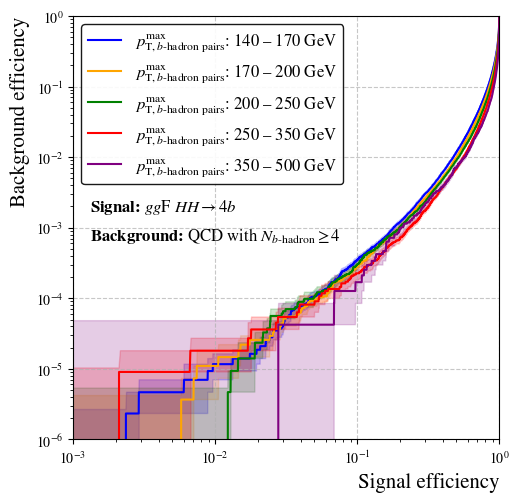

In [13]:
process_list = ['ggHH','QCD']
# process_list = ['ggHH']

pred_folder = "/home/olympus/tyyang99/weaver-core-dev/weaver/pheno/predict"
folder_pattern = "/data/bond/tyyang99/HH4b/sm_incl_derived_4j3bor2b/*"

model_name = "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3"

# Initialize plot
f, ax = plt.subplots(figsize=(5.5, 5.5))
pT_range_list = [(140, 170), (170, 200), (200, 250), (250, 350), (350, 500)]

color_list = ['blue','orange','green','red','purple']

# Preprocess all files once and store data
file_data = []

# Process all matching folders
matching_folders = glob.glob(folder_pattern)
for ifolder in matching_folders:
    proc_name = ifolder.split("/")[-1].split("_")[0]
    if proc_name not in process_list:
        continue
    
    # Determine if signal or background
    is_signal = proc_name in ["ggHH", "qqHH"]
    
    # Process each file in the folder
    matching_files = glob.glob(ifolder + "/*")
    for idxf, ifile in enumerate(matching_files):
        name = proc_name + "_" + ifile.replace(".root","").split("_")[-1]
        # if proc_name=='QCD' and (idxf<=110 or idxf>180) : continue
        # if idxf>40: continue
        print(idxf, name)
        
        # Build file paths
        pred_file = f"{pred_folder}/{model_name}/pred_{name}.root"
        pred_data_tmp = uproot.lazy(pred_file)
        ntuple_data_tmp = uproot.lazy(ifile)
        trigger_selection = ((pred_data_tmp['pass_selection']==1) & (pred_data_tmp['pass_4j3b_selection']==1) & (ak.num(ntuple_data_tmp.gen_bhadron_pt,axis=1)==4))
        pred_data = pred_data_tmp[trigger_selection]
        ntuple_data = ntuple_data_tmp[trigger_selection]

        bhadrons = ak.zip({
            "pt": ntuple_data["gen_bhadron_pt"],
            "eta": ntuple_data["gen_bhadron_eta"],
            "phi": ntuple_data["gen_bhadron_phi"],
            "mass": ntuple_data["gen_bhadron_mass"], 
        }, with_name="PtEtaPhiMLorentzVector")

        b1, b2 = ak.unzip(ak.combinations(bhadrons, 2, axis=1))
        pT_max = ak.max((b1+b2).pt, axis=1)
    
        scores_ALLHH4b = np.zeros_like(pred_data['score_0'])
        for j in range(136):
            scores_ALLHH4b = scores_ALLHH4b + pred_data[f'score_{j}']
        score_hh4bvsqcd = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'])
        
        # Store preprocessed data
        file_data.append({
            'score': ak.to_numpy(score_hh4bvsqcd),
            'pT_max': ak.to_numpy(pT_max),
            'is_signal': is_signal,
            'weight': np.ones(len(pred_data))
        })

# Process each pT range using preloaded data
for i, pT_range in enumerate(pT_range_list):

    icolor = color_list[i]
    
    print('='*30)
    print(pT_range)
    print('='*30)
    
    pT_lower = pT_range[0]
    pT_upper = pT_range[1]
    
    signal_data = []
    background_data = []
    
    for data in file_data:
        pT_cut = ((data['pT_max'] >= pT_lower) & (data['pT_max'] < pT_upper))
        
        # Apply pT cut
        weighted_data = {
            'score': data['score'][pT_cut],
            'weight': data['weight'][pT_cut]
        }
        
        if data['is_signal']:
            signal_data.append(weighted_data)
        else:
            background_data.append(weighted_data)
    
    # Extract scores and weights
    y_score_s = np.concatenate([d['score'] for d in signal_data]) if signal_data else np.array([])
    y_score_b = np.concatenate([d['score'] for d in background_data]) if background_data else np.array([])
    
    # Combine scores and labels
    y_score = np.concatenate([y_score_s, y_score_b])
    y_true = np.concatenate([np.ones_like(y_score_s), np.zeros_like(y_score_b)])
    
    # Remove NaN values
    valid_mask = ~np.isnan(y_score)
    print("Num of nan_score:", np.sum(~valid_mask))
    y_true = y_true[valid_mask]
    y_score = y_score[valid_mask]
    
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = m.roc_curve(y_true, y_score)
    auc = m.auc(fpr, tpr)

    # Convert to numpy if not already
    y_score_b_np = np.asarray(y_score_b)
    
    # Calculate total raw background (unweighted)
    total_raw_b = len(y_score_b_np)
    if total_raw_b == 0:
        background_lower = np.zeros_like(thresholds)
        background_upper = np.zeros_like(thresholds)
    else:
        # Efficiently calculate raw_background_passed for each threshold (vectorized, no loop)
        sorted_indices = np.argsort(-y_score_b_np)  # Descending sort indices
        sorted_scores = y_score_b_np[sorted_indices]
        cum_passed = np.arange(1, total_raw_b + 1)  # Cumulative counts: 1 to total_raw_b
    
        # Find the positions in sorted_scores for each threshold
        # For each thresh, find the smallest index where sorted_scores < thresh (i.e., passed = index)
        passed_counts = np.searchsorted(sorted_scores, thresholds, side='left')  # Efficient binary search
        raw_background_passed = total_raw_b - passed_counts  # Wait, no: since descending, adjust
        # Correct: np.searchsorted on descending sorted needs inversion
        # Better: since roc_curve thresholds are decreasing, and fpr = passed_b / total_b where passed_b = sum(score_b >= thresh)
        # Use: sort ascending, then cumsum from the end
        sorted_scores_asc = np.sort(y_score_b_np)  # Ascending
        # For thresh, passed = sum(score >= thresh) = total - sum(score < thresh)
        pos = np.searchsorted(sorted_scores_asc, thresholds, side='right')  # Number of scores < thresh
        raw_background_passed = total_raw_b - pos  # Number >= thresh
    
        # Now calculate Poisson intervals for each raw_N
        lower_raw, upper_raw = poisson.interval(0.68, raw_background_passed)  # 68% CL, returns arrays of floats
        upper_raw[raw_background_passed == 0] = -np.log(1 - 0.68) # ≈1.139 for one-sided upper limit
        
        # Convert to weighted
        background_lower = lower_raw / total_raw_b
        background_upper = upper_raw / total_raw_b

    # Convert efficiencies to event counts
    signal_events = tpr 
    background_events = fpr 

    background_lower = np.maximum(background_lower, 1e-10)

    # Plot uncertainty band first
    ax.fill_between(signal_events, background_lower, background_upper, color=icolor, alpha=0.2)

    # Plot ROC curve
    ax.plot(signal_events, background_events, 
            color=icolor, 
            label="$p_{\\mathrm{T},b\\text{-}\\mathrm{hadron~pairs}}^{{\\mathrm{{max}}}}$: "+f"${pT_lower}" + "~–~" + f"{pT_upper}$ GeV")
            # label=f"$p_T$ (b-had pair, max): {pT_lower}-{pT_upper} GeV (AUC: {auc:.4f})")

# Set plot properties (unchanged)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1e-3, 1)
ax.set_ylim(1e-6, 1)
ax.set_xlabel(r'Signal efficiency', ha='right', x=1.0, fontsize=15)
ax.set_ylabel('Background efficiency', ha='right', y=1.0, fontsize=15)

ax.text(0.04, 0.54, r'Signal: $gg\mathrm{F}~HH\rightarrow 4b$', fontsize=12, fontweight='bold', transform=ax.transAxes)
ax.text(0.04, 0.47, r'Background: $\mathrm{QCD~with}$ $N_{b\text{-}\mathrm{hadron}} \geq 4$', fontsize=12, fontweight='bold', transform=ax.transAxes)
# ax.text(1.0, 1.01, r'$\mathcal{L} = 450$ fb$^{-1}$', fontsize=15, 
        # transform=ax.transAxes, ha='right', va='bottom')

ax.legend(loc='upper left', framealpha=0.9, edgecolor='black', fontsize=12)

# Save plot
plt.savefig('PLOTS/LorentzBoostRangeCompare.pdf', dpi=300, bbox_inches='tight')
plt.savefig('PLOTS/LorentzBoostRangeCompare.png', dpi=300, bbox_inches='tight')
plt.show()